In [1]:

from matplotlib import pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from collections import Counter
from sklearn import ensemble
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.cluster import SpectralClustering
from sklearn.cluster import spectral_clustering
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D

import spacy

sns.set(rc={'figure.figsize':(12,7)}, style='whitegrid', color_codes=True)

/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Source = http://jmcauley.ucsd.edu/data/amazon/ 

## Challenge: Compare the stability or accuracy of text classifcation between clustering 

## and supervised modelling

### Overview:
#### 1) Data preprocessing
#### 2) Generation of TF_IDF features (Supervised technique) and dimensionality reduction by SVD (Unsupervised technique)
#### 3) Evaluation of models with TF_IDF features
#### 4) Generation of word2vec features (Unsupervised technique)
#### 5) Evaluation of models with Word2vec features
#### 6) Clustering of data and Evalutaion
#### 7) Conlusions: why Modelling is better than clustering. 

### 1) Data preprocessing

In [2]:
#df =  pd.read_csv('/Users/Sri/Downloads/Amazon_Books_Review.csv')
df = pd.read_json('Amazon_Instant_Video_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400


In [4]:
df.overall.value_counts(normalize=True)

5    0.562678
4    0.227496
3    0.112778
2    0.050773
1    0.046275
Name: overall, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.8+ MB


In [6]:
# Making a subset dataframe of only the columns which are necessary for analysis.
data=df[['reviewText', 'overall']]

In [7]:
# Making a subset of the data for faster run time
#ata = data.sample(frac=0.005, replace=False, random_state=1)
data = data.sample(frac=0.1, replace=False, random_state=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3713 entries, 19223 to 2538
Data columns (total 2 columns):
reviewText    3713 non-null object
overall       3713 non-null int64
dtypes: int64(1), object(1)
memory usage: 87.0+ KB


In [9]:
data.head()

,reviewText,overall
19223,i saw the series on TV and wasn;t too imressed...,5
8564,I love police procedurals. My favorite is the ...,5
10406,"Very good well written series, so sorry it di...",3
14717,"One episode in, I plan to watch another. The a...",3
2554,"This is a wild ride, on the one hand we've got...",5


In [10]:
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

In [11]:
# Deleting the null values since they represent 0.006% of the data.
data.dropna(inplace=True, axis=0)
data.reset_index(inplace=True, drop=True)

In [12]:
data.overall.unique()

array([5, 3, 4, 2, 1])

In [13]:
# Creating outcome variable i.e review_sentiment as positive or negative
data['review_sentiment'] = np.where(data['overall'] > 3, 1, 0)

In [14]:
data.head()

,reviewText,overall,review_sentiment
0,i saw the series on TV and wasn;t too imressed...,5,1
1,I love police procedurals. My favorite is the ...,5,1
2,"Very good well written series, so sorry it di...",3,0
3,"One episode in, I plan to watch another. The a...",3,0
4,"This is a wild ride, on the one hand we've got...",5,1


Before doing any of the next steps we need to extract the revies as positive or negative for creating features category wise.

In [15]:
all_reviews_positive=[]
all_reviews_negative=[]

for text in (data.loc[data['review_sentiment'] == 1, 'reviewText'].values):
    all_reviews_positive.append(text)
    
for text in (data.loc[data['review_sentiment'] == 0, 'reviewText'].values):
    all_reviews_negative.append(text)

In [16]:
all_reviews_positive[2]

'This is a wild ride, on the one hand we\'ve got this incredibly hyper violent bike gang made up of some really good guys. Seriously who would NOT want to go out for a beer with jackson, Opie, Chips, Scotty, Juice or Bobby Elvis?? Clay is another matter. Then there is the comparative morality of corrupt politicians, cynical, venal government agencies and morally compromised businessmen. So they get into all of these wild escapades, nothing is ever what it seems and the SOA is always about 15 minutes from death, destruction and prison as one scheme after another backfires. Someone should make a reel of the many "oh s***" moments in the series, whenever someone says it, it has already hit the fan. But it is never boring. I guarantee that if you buy the series you will be up all night watching it, simply to see what happens next. Highest possible rating.'

In [17]:
len(all_reviews_positive)

2954

In [18]:
len(all_reviews_negative)

759

In [19]:
# Finding the length of each review for 10 rows
for i in range(10):
    print (len (data['reviewText'][i]))

341
413
110
169
861
237
505
277
1462
111


Some of them have pretty long reviews. More the words better it is for word training.

Since the size of the text is greater than 1 million, Spacy gives an error. so broken down the text into a list of strings.

In [20]:
# Parsing the texts
nlp = spacy.load('en')

all_reviews_positive_list_doc = [ nlp(text) for text in all_reviews_positive]
all_reviews_negative_list_doc = [ nlp(text) for text in all_reviews_negative]

### Data cleaning / processing / language parsing

In [21]:
# Cleaning the texts and making the words ready for further processing

all_reviews_list_cleaned_doc=[]
temp=''         
for review in all_reviews_positive_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''
        
for review in all_reviews_negative_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''

###  2) Generation of TF_IDF features (Supervised technique) and dimensionality reduction by SVD   
### (Unsupervised technique)

### TF-IDF Feature generation and selection/reduction with SVD

In [22]:
def tf_idf_svd_normalizer(doc):
    from sklearn.feature_extraction.text import TfidfVectorizer


    vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
    #Applying the vectorizer
    review_tfidf=vectorizer.fit_transform(doc)
    print("Number of features: %d" % review_tfidf.get_shape()[1])

    from sklearn.decomposition import TruncatedSVD
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer

    #Our SVD data reducer.  We are going to reduce the feature space.
    n = int((review_tfidf.get_shape()[1])/5)
    print ('Dimension Reduction from %d to %d' % (review_tfidf.get_shape()[1], n))
    svd= TruncatedSVD(n)
    #lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD.
    review_lsa = svd.fit_transform(review_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("\nPercent variance captured by all components:",total_variance*100)
    reviews_by_component=pd.DataFrame(review_lsa, index=doc)

    return reviews_by_component, review_tfidf

In [23]:
len(all_reviews_list_cleaned_doc)

3713

In [24]:
reviews_by_component_original, review_tfidf = tf_idf_svd_normalizer(all_reviews_list_cleaned_doc)

Number of features: 9544
Dimension Reduction from 9544 to 1908

Percent variance captured by all components: 89.86877354871659


In [25]:
review_tfidf

<3713x9544 sparse matrix of type '<class 'numpy.float64'>'
	with 121976 stored elements in Compressed Sparse Row format>

In [26]:
reviews_by_component_original.head()

,0,1,2,3,4,5,6,7,8,9,...,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907
i saw the series on tv and too imressed the second time around was much much story line moves effortlessly the characters are intriguing and the suspense is superb i highly recommend this series to all who would enjoy horror with a great story line also see the first american horror story that is really really good,0.298499,-0.112400,0.138161,-0.197416,0.010027,0.106044,-0.154466,-0.032914,-0.054195,0.101880,...,-0.006460,-0.010283,-0.005475,0.008490,0.007519,-0.000845,0.004776,-0.008953,-0.001267,-0.007183
i love police procedurals my favorite is the swedish wallander so that the standard i compare others against and single handed does a great job of entertaining me and making me want to see more the acting is superb so much so that you can forget they are actors and believe in these complicated people their small town on the western edge of ireland and the tough lives they lead i enjoyed every minute,0.142418,-0.045729,0.074410,0.024398,0.053790,-0.031364,-0.067318,-0.018246,0.015167,0.018415,...,0.008725,-0.001669,-0.000524,0.013131,-0.001843,0.021747,0.013827,-0.021818,0.007169,-0.010865
this is a wild ride on the one hand we got this incredibly hyper violent bike gang made up of some really good guys seriously who would not want to go out for a beer with jackson opie chips scotty juice or bobby elvis clay is another matter then there is the comparative morality of corrupt politicians cynical venal government agencies and morally compromised businessmen so they get into all of these wild escapades nothing is ever what it seems and the soa is always about minutes from death destruction and prison as one scheme after another backfires someone should make a reel of the many oh s moments in the series whenever someone says it it has already hit the fan but it is never boring i guarantee that if you buy the series you will be up all night watching it simply to see what happens next highest possible rating,0.102104,-0.034256,-0.004800,-0.019457,-0.065734,0.023796,-0.010851,0.033352,0.013031,-0.017299,...,-0.006127,0.004363,-0.016262,-0.012378,-0.005392,0.009119,-0.001293,0.014890,0.009759,0.012852
i like this tv series which nowadays may not last too long for reasons i can only guess at i have the other seasons and just want to complete my collection if you have seen any of the shows try season and see what you think of it,0.253275,0.068843,-0.039278,0.019491,-0.131146,-0.040717,0.010407,-0.024224,0.106662,-0.184526,...,0.005944,-0.019622,0.005067,-0.001014,0.005285,0.006177,-0.003845,-0.005706,-0.015572,-0.002230
i liked it a girl goes to a party and either a guy gives her some sort of terrible or puts something deadly in her drink eithier way we see a downward spiral to her health and apperance man i love horror movies but there soooo much bunk out there i found this well acted good plot and action i was puzzeled by the total ignorant doctor who ca seem to help and mother who thinks she s on drugs when she s clearly turning into something other worldly but hey its a movie and a good one,0.130296,-0.079036,-0.067046,0.025261,0.097886,0.071779,-0.051153,0.095807,0.017944,-0.009975,...,0.011736,0.000789,-0.011550,-0.006073,0.007587,0.008955,-0.009020,-0.006600,0.005432,0.010452


In [27]:
#Scaling data for plotting the PC1 and PC2 plots in the next few cells
X1 = scale(reviews_by_component_original)

In [28]:
#Adding review sentiment to the final dataframe with tfidf values
reviews_by_component_original.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

reviews_by_component_original['review_sentiment'] = 0
reviews_by_component_original.loc[0:len(all_reviews_positive_list_doc)-1, 'review_sentiment'] = 1

In [29]:
reviews_by_component_original.head()

,0,1,2,3,4,5,6,7,8,9,...,1899,1900,1901,1902,1903,1904,1905,1906,1907,review_sentiment
0,0.298499,-0.112400,0.138161,-0.197416,0.010027,0.106044,-0.154466,-0.032914,-0.054195,0.101880,...,-0.010283,-0.005475,0.008490,0.007519,-0.000845,0.004776,-0.008953,-0.001267,-0.007183,1
1,0.142418,-0.045729,0.074410,0.024398,0.053790,-0.031364,-0.067318,-0.018246,0.015167,0.018415,...,-0.001669,-0.000524,0.013131,-0.001843,0.021747,0.013827,-0.021818,0.007169,-0.010865,1
2,0.102104,-0.034256,-0.004800,-0.019457,-0.065734,0.023796,-0.010851,0.033352,0.013031,-0.017299,...,0.004363,-0.016262,-0.012378,-0.005392,0.009119,-0.001293,0.014890,0.009759,0.012852,1
3,0.253275,0.068843,-0.039278,0.019491,-0.131146,-0.040717,0.010407,-0.024224,0.106662,-0.184526,...,-0.019622,0.005067,-0.001014,0.005285,0.006177,-0.003845,-0.005706,-0.015572,-0.002230,1
4,0.130296,-0.079036,-0.067046,0.025261,0.097886,0.071779,-0.051153,0.095807,0.017944,-0.009975,...,0.000789,-0.011550,-0.006073,0.007587,0.008955,-0.009020,-0.006600,0.005432,0.010452,1


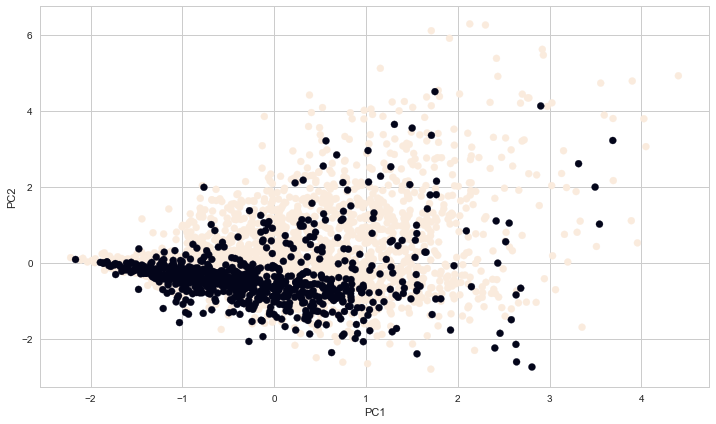

In [30]:

#Plotting the data of TF_IDF and Word2vec features together as SVD components
plt.scatter(X1[:, 0], X1[:, 1], c=reviews_by_component_original['review_sentiment'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [31]:
# To schuffle samples


reviews_by_component = reviews_by_component_original.sample(frac=1, replace=False, random_state=2)
reviews_by_component.reset_index(drop=True, inplace=True)

# Splitting data into X and Y
Y = reviews_by_component['review_sentiment']
X = reviews_by_component.loc[:, ~(reviews_by_component.columns).isin(['review_sentiment'])]

In [32]:
reviews_by_component.head()

,0,1,2,3,4,5,6,7,8,9,...,1899,1900,1901,1902,1903,1904,1905,1906,1907,review_sentiment
0,0.160905,-0.102257,-0.098262,0.026551,-0.003946,-0.003550,-0.008354,-0.062904,0.009398,0.003784,...,0.009534,-0.013625,-0.006741,0.007281,0.003687,-0.003465,-0.004064,0.022796,-0.023230,0
1,0.102133,-0.025592,0.030056,-0.023409,0.034973,-0.077979,0.018102,-0.004556,-0.003824,-0.086631,...,0.026142,-0.011362,0.005562,0.008676,-0.003591,-0.010985,0.002083,0.013415,0.014989,1
2,0.187413,-0.077934,0.045013,0.022424,-0.008640,0.095225,-0.097625,-0.022145,-0.004134,0.003956,...,0.008031,0.006879,0.003387,-0.010697,0.003762,-0.001739,-0.003597,-0.000193,0.007170,1
3,0.118752,-0.030300,0.070424,-0.042101,-0.147485,0.060381,-0.040060,0.021320,-0.026616,-0.002801,...,-0.012731,0.005649,0.010962,0.003628,-0.001695,-0.005032,-0.004046,-0.002777,-0.011828,1
4,0.117553,-0.026674,-0.035170,-0.037243,-0.017708,-0.013033,-0.043839,-0.009966,0.091136,0.040734,...,-0.012110,0.018684,-0.014368,0.018775,0.002638,0.007887,0.000425,-0.010877,0.003067,1


In [33]:
np.array(Y.T)

array([0, 1, 1, ..., 1, 1, 0])

In [34]:
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2954, 0: 759})


There is a lot of class imbalance here. Need to correct the problem before going further by over sampling and under sampling (SMOTE).

In [35]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({0: 2954, 1: 2954})


Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [36]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['sentiment'])

Xt = X.sample(frac=1, replace=False, random_state=2)
Yt = Y.sample(frac=1, replace=False, random_state=2)

Xt.reset_index(drop=True, inplace=True)
Yt.reset_index(drop=True, inplace=True)
Yt = Y['sentiment']

#Saving the data for further use with clustering as Xs and Ys
X = Xt
Y = Yt

In [37]:
print('Number of review samples per each class\n {}'.format(Counter(np.array(Y))))

Number of review samples per each class
 Counter({0: 2954, 1: 2954})


In [38]:
np.array(Y)

array([0, 1, 1, ..., 0, 0, 0])

### 3) Evaluation of models with TF_IDF features


###  Model assessment and evalution with other models

Before going with Model assessment created a function to handle this everytime we test a model

In [39]:
def model(mod, X=X, Y=Y):
    model_object=mod
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=3)
    model_object.fit(X_train, y_train)
    print ("Model train score is %0.2f" % (model_object.score(X_train, y_train)) )
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=10)
    print ('\nCross_validation scores below :\n', score)
    print("\nMean/test accuracy: %0.2f (+/- %0.2f)\n" % (score.mean(), score.std() * 2))
    
    y_pred=model_object.predict(X_test)
  
   #Plotting the ROC-AUC curve   
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', linewidth=4,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fancybox=True, fontsize='large')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ("\n_______________Contingency table analysis:_________\n")
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    return

In [40]:
### Logistic Regression

/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model train score is 0.84


/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached w


Cross_validation scores below :
 [0.53691275 0.51677852 0.41891892 0.5        0.53378378 0.49659864
 0.49659864 0.53061224 0.51020408 0.53061224]

Mean/test accuracy: 0.51 (+/- 0.07)



/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


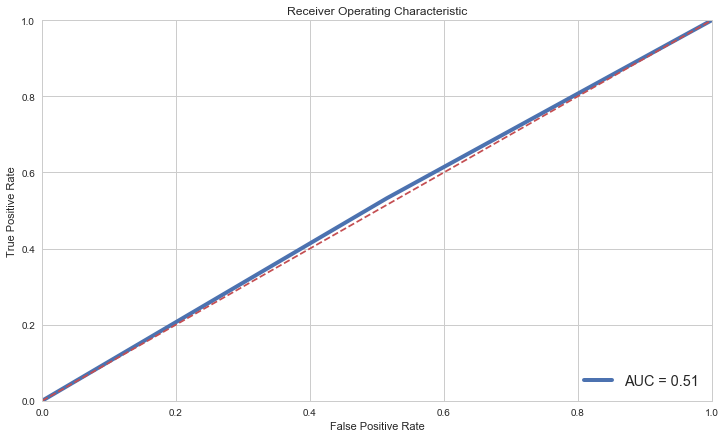


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 53.191489% 
The specificity i.e true negatives is 48.551724% 
The Type I error i.e. false negatives is 46.808511% 
The Type II error i.e. false positives is 51.448276% 


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
model(LogisticRegression(C=1e9, solver='saga', max_iter=200))

In [ ]:
### Gradient Boost Classifier

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
model(ensemble.GradientBoostingClassifier(**params))

In [ ]:
model(SVC(gamma='auto'))

In [ ]:
#model(MultinomialNB(), Xt, Yt)

The Logistic regression gives the best AUC of 0.91. percent 80% test accuracy and also low errors compared to other models.

Using neural networks model for text classification

In [ ]:
model(MLPClassifier(hidden_layer_sizes=(1000,2)), Xt, Yt)

The neural network MLP classifer does not perform better than other models discussed above.

### 4) Generation of word2vec features (Unsupervised technique)

### Word2Vec Unsupervised Feature generation

In [ ]:
# We cannot use list of strings for word2vec. need list of lists
for item in all_reviews_list_cleaned_doc:
    print (type (item))
    break

In [ ]:
# Cleaning the texts and making the reviews as a list of lists needed for word2vec.

all_reviews_list_cleaned_doc = []
all_reviews_positive_list_cleaned_doc = []
all_reviews_negative_list_cleaned_doc = []
temp=[]         
for review in all_reviews_positive_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and not token.is_stop and  token.is_alpha:
            temp.append(token.text.lower())
    all_reviews_positive_list_cleaned_doc.append(temp)
    temp=[]
        
for review in all_reviews_negative_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and not token.is_stop and  token.is_alpha:
            temp.append(token.text.lower())
    all_reviews_negative_list_cleaned_doc.append(temp)
    temp=[]
all_reviews_list_cleaned_doc = all_reviews_positive_list_cleaned_doc+all_reviews_negative_list_cleaned_doc

In [ ]:
#Just checking whether each item in the list is a list or not since it is a requirement for Word2Vec
for item in all_reviews_list_cleaned_doc:
    print ((item))
    print (type(item))
    break

In [ ]:
len(all_reviews_list_cleaned_doc)

In [ ]:
import gensim 
model_W2V = gensim.models.Word2Vec (all_reviews_list_cleaned_doc, size=200, window=5, min_count=2, workers=10)

model_W2V.train(all_reviews_list_cleaned_doc,total_examples=len(all_reviews_list_cleaned_doc),epochs=10)

In [ ]:
vocab=model_W2V.wv.vocab.keys()

In [ ]:
print (type(vocab))

In [ ]:

model_W2V.wv.most_similar (positive='cool')

In [ ]:
model_W2V.wv['cool'] # Wanted to see the word to vector form

In [ ]:
# Normalizes the word2vec vectors
model_W2V.init_sims(replace=True)

# remove out-of-vocab words
word2vecFeature = np.zeros((len(all_reviews_list_cleaned_doc),200))
for i,doc in enumerate(all_reviews_list_cleaned_doc): 
    
    doc = [word for word in doc if word in vocab]
    
    word2vecFeature[i,:] = np.mean(model_W2V[doc],axis=0)

#colName = getColName(300, "w2v")
word2vecFeature = pd.DataFrame(word2vecFeature)
word2vecFeature.head()

In [ ]:
word2vecFeature.shape

In [ ]:
# Adding the outcome variable to the data.
word2vecFeature['review_sentiment'] = 0
word2vecFeature.loc[0:len(all_reviews_positive_list_cleaned_doc)-1, 'review_sentiment'] = 1
word2vecFeature.head()

In [ ]:
# Slitting into x and y
Y = word2vecFeature['review_sentiment']
X = word2vecFeature.loc[:, ~(word2vecFeature.columns).isin(['review_sentiment'])] 
print('Number of review samples per each class\n {}'.format(Counter(Y)))

In [ ]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [ ]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['review_sentiment'])


Xw = X.sample(frac=1, replace=False, random_state=2)
Yw = Y.sample(frac=1, replace=False, random_state=2)

Xw.reset_index(drop=True, inplace=True)
Yw.reset_index(drop=True, inplace=True)

#Saving the data for later use for clustering
Yw = Y['review_sentiment']
X = Xw
Y = Yw

In [ ]:
X.head()

### 5) Evaluation of models with Word2vec features


###  Model assessment and evalution with other models

In [ ]:
### Gradient Boost Classifier

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
model (ensemble.GradientBoostingClassifier(**params))

In [ ]:
### Logistic Regression

In [ ]:
model(LogisticRegression(C=1e9, solver='saga', max_iter=200))

In [ ]:
### SVC

In [ ]:
model(SVC(gamma='auto'))

In [ ]:
#model(MultinomialNB(), Xt, Yt)

#####  With word2vec alone an accuracy of 75% is got . Now howabout if we add the TFIDF features.

In [ ]:
# Slitting into x and y

word2vecFeat_TFIDF=pd.DataFrame()

columns_to_copy = reviews_by_component_original.columns[~(reviews_by_component_original.columns).isin(['review_sentiment'])]

for name in columns_to_copy:
    word2vecFeat_TFIDF[str(name)+'tf_idf'] = reviews_by_component_original[name]
    
word2vecFeat_TFIDF['review_sentiment'] = reviews_by_component_original['review_sentiment']

Y = word2vecFeat_TFIDF['review_sentiment']
X = word2vecFeat_TFIDF.loc[:, ~(word2vecFeat_TFIDF.columns).isin(['review_sentiment'])] 
print('Number of review samples per each class\n {}'.format(Counter(Y)))
word2vecFeat_TFIDF.head()

In [ ]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [ ]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['review_sentiment'])


X = X.sample(frac=1, replace=False, random_state=2)
Y = Y.sample(frac=1, replace=False, random_state=2)

X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)

Y = Y['review_sentiment']

In [ ]:
X.head()

In [ ]:
# Needs to be standardized by scaling
#from sklearn.preprocessing import scale
X1 = scale(X)

In [ ]:
#Plotting the data of TF_IDF and Word2vec features together
# Getting the X data from TF-IDF data and converting into an array for plotting i.e PC1 and PC2
X1=np.array(Xt)
plt.scatter(X1[:, 0], X1[:, 1], c=Y, cmap='viridis')
plt.show()

In [ ]:
### Gradient Boost Classifier

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
model(ensemble.GradientBoostingClassifier(**params))

Still the accuracy was only around 76% with Gradient boost classifier

## 6) Clustering of data and Evaluation

#### All the data used for TF-IDF have undegone dimension reduction by SVD and so the first three components are used here to visualize

#### Before going with the clustering lets us first define some functions to make to easier to build and analyse the clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy import cluster
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score



In [ ]:
def cluster_plot(mod, X=Xt, Y=Yt):
    print ('\nProjecting the data on a 3D scatter plot')
    sns.set(rc={'figure.figsize':(15,10)}, style='whitegrid', color_codes=True)
    #Plotting the TF_IDF data i.e Xt
    X=np.array(X)
    mod.fit(X)
    labels = mod.labels_
    centers=model_k.cluster_centers_

    fig = plt.figure(1, figsize=(15, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    ax.scatter(X[:, 0], X[:, 1],X[:, 2],
               c=labels.astype(np.float), edgecolor='c', cmap = 'prism',marker='o', s=60)
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Text classification')
    ax.dist = 12
    plt.show()
    return


In [ ]:
def clust_ROC_contingency(mod, X=X, Y=Y):
    model_object=mod
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=3)
    model_object.fit(X_train)
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    y_pred=model_object.labels_
  
   #Plotting the ROC-AUC curve   
    fpr, tpr, threshold = metrics.roc_curve(y_train, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', linewidth=4,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fancybox=True, fontsize='large')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ("\n_______________Contingency table analysis:_________\n")
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    
    return

In [ ]:
#Evaluating the kmeans clustering
# Evaluate the performance of the clusters

def cluster_adj_rand_index(mod):
    #Testing with the 25% holdout group
    X_train, X_test, y_train, y_test = train_test_split(Xt, Yt, test_size=0.25, random_state=3)
    mod.fit(X_train)
    y_pred=mod.labels_
    y_train=np.array(y_train)
    print ("________ADJUSTED RANDOM INDEX________\n")
    print ("ARI of 0 means random labelling and 1 indicates perfect labelling as expected")
    print('\nAdjusted Rand Index: {:0.2f}'.format(adjusted_rand_score(y_train, y_pred)))
    return

In [ ]:
#Evaluating the stability of clustering method

def cluster_stability(mod):
    print ("______________CLUSTER SIMILARITY/STABILTIY___________\n")
    print('Testing how stable is the clustering method by Silhouette_score:')
    print ('The range of Silhouette score is from -1 for bad clusters to +1 for dense clusters.\n')
    for i in range(1,6):
        X_train, X_test, y_train, y_test = train_test_split(Xt, Yt, test_size=0.25, random_state=i)
        modClust = mod
        modClust.fit(X_train)
        labels = modClust.labels_
        print(metrics.silhouette_score(X_train, labels, metric='euclidean'))
    
    return

## K Means clustering

Elbow plot to find number of clusters 'k'

In [ ]:
#plot variance for each value for 'k' between 1,10

initial = [cluster.vq.kmeans(Xt,i) for i in range(1,5)]
plt.plot([var for (cent,var) in initial])
plt.xlabel(' K values')
plt.ylabel('Distortions')
plt.title("Elbow plot")
plt.show()

The Elbow plot above shows that the elbow or the kink is at two clusters suggesting 2 clusters which is great since that is what we want our model to expect to classify reviews by positive and negative.

In [ ]:
# Projecting the data on a 2D scatter plot.

In [ ]:
# Plotting the clusters using a Scipy tool for Kmeans. (Scipy has this method only for Kmeans clustering method)

cent, var = initial[1] # initial value of 1 means two clusters. i.e one has to be reduced 
model_k = KMeans(n_clusters=2, init='k-means++', n_init=20)
model_k.fit(Xt)
centers = model_k.cluster_centers_
#use vq() to get as assignment for each obs.
assignment,cdist = cluster.vq.vq(X1,cent)
plt.scatter(X1[:,0], X1[:,1], c=assignment, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title ("Clustering by K-Means")
plt.show()

In [ ]:
cluster_plot(KMeans(n_clusters=2, init='k-means++', n_init=20))

In [ ]:
clust_ROC_contingency(KMeans(n_clusters=2, init='k-means++', n_init=20))

In [ ]:
cluster_adj_rand_index(KMeans(n_clusters=2, init='k-means++', n_init=20))

In [ ]:
cluster_stability(KMeans(n_clusters=2, init='k-means++', n_init=20))

In [ ]:
model_k =KMeans(n_clusters=2)
model_k.fit(Xt)
centers=model_k.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.scatter(X1[:,0], X1[:,1], c=assignment, cmap='viridis')
plt.show()

Methods of evaluation above show that Kmeans did not perform well in terms of stabilty as per the score range requirements and also clustering.

## Mean shift clustering

In [ ]:
# Mean shift used here to estimate the number the clusters.,..It estimated based on data that it is all 
#one cluster
from sklearn.cluster import MeanShift, estimate_bandwidth

#Using the TF_IDF data which is Xt
bandwidth = estimate_bandwidth(Xt, quantile=0.1, n_samples=Xt.shape[0])
ms = MeanShift(bandwidth=1, bin_seeding=True)
ms.fit(Xt)
labels = ms.labels_
n_clusters_=len(np.unique(labels))
print("\nNumber of estimated clusters by the algorithm: {}".format(n_clusters_))

Mean shift clusters the data as One cluster only.

In [ ]:
# Visualizing the cluster labelling of the Meanshift method using the model object ms
cluster_plot(MeanShift())

The above visualization and below evalution of clustering is doesnot make sense since meanshift determined the number of clusters to be one but the data we are trying to classify has binary output i.e positive or negative.

In [ ]:
#clust_ROC_contingency(MeanShift())

In [ ]:
#cluster_adj_rand_index(MeanShift())

In [ ]:
# cluster_stability(MeanShift())

## Affinity Propagation clustering

In [ ]:
cluster_plot(AffinityPropagation())

#### Affinity propagation is known for predicting absurdly high clusters and we can see here that there lot of colours/cluster predicted.

In [ ]:
clust_ROC_contingency(AffinityPropagation())

In [ ]:
cluster_adj_rand_index(AffinityPropagation())

In [ ]:
cluster_stability(AffinityPropagation())

## Spectral clustering

In [ ]:
cluster_plot(SpectralClustering(n_clusters=2))

In [ ]:
clust_ROC_contingency(SpectralClustering(n_clusters=2))

In [ ]:
cluster_adj_rand_index(SpectralClustering(n_clusters=2))

In [ ]:
cluster_stability(SpectralClustering(n_clusters=2))

### 7) Conlusions: why Modelling is better than clustering. 

First of all, I like Clustering as a technique to visualize the datapoints and see how the datapoints fall as samples to give an idea. It is also a great unsupervised model for getting the feel of data. Secondly, it is good for unlabelled data to quickly know the groups. The two groups expected here the positive and reviews to some extent could be visualized. The demarcation or the boundary of the two groups was more evident in 3D graphing compared to 2D as in hyper dimensional space with mulit-dimensions it is hard to see that data in 2D and expect to find clusters or segregated groups. However, with 3D it was little better in visualizing the clusters and the boundarys or segregation into groups.

Clustering model methods are harder to evaluate compared to the all the supervised modelling methods. The Evalution or assessment of the results by clustering methods are mostly difficult to measure due to its inherent inexactness. When it comes to accuracy supervised models performed much better in accurately classifying the texts as positive or negative. This is especially seen with the errors in the contingency table, very high errors in classifying texts, where as the supervised models had very low error rates.

With RandIndex and Silhouette coefficient  were used to evaluate the similarity of datapoints in cluster and stability of the model. The results were not great either. Atleast with this dataset it did not do a great job in clustering similar datapoints as per these two metrics. 

Clustering has a single phase of implementation i.e only fitting the data to the model unlike classification supervised models which also involves the mainly the testing phase. Although we tried to test or see how the clusters have segregated compared to expected, there is no test accuracy scores etc. for clustering.

###### Future Scope: The model can be further enhanced even more using sentence2vec or doc2vec embedding to generalize more.